In [1]:
import scipy.io
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
from sklearn import model_selection, metrics
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score

# import seaborn as sns
import scipy.io as sio
from scipy.stats import beta

### 1. Download and import the Santander dataset. 
The labels of the test data are not publicly available, so create your own test set by randomly choosing half of the instances in the original training set. 


In [2]:
# Data import
data = pd.read_csv("train.csv")

# Displaying 3 first rows of data
display(data[:3])

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965


In [3]:
# Function to check if we have missing values
def printMissing(dataframe):
    total = dataframe.isnull().sum().sort_values(ascending=False)
    percent = (dataframe.isnull().sum()/dataframe.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    display(missing_data[missing_data['Total']>0])
    
# printMissing(data)

printMisisng function showed that 0.000009% of data are NA

In [4]:
# Remove the rows with NA values
data_clean = data.dropna() 
print('Number of rows removed', (data.shape[0] - data_clean.shape[0]) )

Number of rows removed 1


In [5]:
# Rescale the data (min-max normalization)
def rescaled_X(X): 
    X_normed = (X -X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))    
    return  X_normed 

In [6]:
# Change the dataframe to numpy array
np_data = data_clean.values

# Extract target and x from data
y = np_data[:,[1]].copy()
x = np_data[:,2:].copy()

# Rescale data and add columns of 1 to X matrix
x= rescaled_X(x)
X = np.c_[ np.ones(len(x)),x].astype(float)


In [7]:
# Split data to train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state=7)

### 2.  Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis

In [8]:
# Shape of X matrix
print('Shape of X:', X.shape)

# Shape of y matrix
print('Shape of y:',y.shape)

Shape of X: (109097, 201)
Shape of y: (109097, 1)


X matrix has 109097 rows and 201 features (including the 1-column). Number of dimensions have an impact on the efficiency (speed) of the code.

In [9]:
# Distribution of class labels
uniquetarget = data.groupby('target').target.count()
display(uniquetarget)

target
0    98164
1    10934
Name: target, dtype: int64

Target 0 class is almost 10 times more numerous that target 1 class. It means that our dataset is unbalanced. Dealing with unbalanced data is harder (as the final model will predict better on more numerous class). To check accuracy of prediction for unbalanced data it is important to choose correct metrics (like f1 score).

### 3a. Implement Bayesian linear regression

In [10]:
#Choose of covariance of prior density 
def get_S_matrix(X):
    variableNumber= X.shape[1]
    S = np.diag(np.diag(np.random.rand(variableNumber,variableNumber))) 
    return S.astype(float)

Function to compute the matrix form of the least squares:
\begin{equation*}
\hat{w} = (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{X}^T t
\end{equation*}

In [11]:
#Compute w_hat (likelihood)
def compute_w_hat(X, y):   
    Xt = np.transpose(X)
    w_hat = np.linalg.inv(Xt.dot(X)).dot(Xt).dot(y.reshape((len(y), 1)))
    return w_hat

To compute $\hat{\sigma^2}$ we use:

\begin{equation}
\hat{\sigma^2} = \frac{1}{N}(\mathbf{t}-\mathbf{X}\hat{\mathbf{w}})^T (\mathbf{t}-\mathbf{X}\hat{\mathbf{w}})
\end{equation}

In [12]:
def sigmasquare(w_hat, X, y):
    return float((((y-X.dot(w_hat))).T.dot(y-X.dot(w_hat)))/y.size)

Covariance matrix of posterior density:
\begin{equation}
\mathrm{SIGMA} = (\frac{1}{\sigma^2} \mathbf{X}^T\mathbf{X}+\mathbf{S}^{-1})^{-1}
\end{equation}

In [13]:
# Posterior variance of the weights:
def covarianceMatrix(X, sigmasquare2, S):
      return np.linalg.inv(X.T.dot(X)/(sigmasquare2)+np.linalg.inv(S))
#     return (1/(sigmasquare2))*np.linalg.inv(X.T.dot(X)+np.linalg.inv(S))



In [14]:
# Mean vector of posterior density:
def mean(sigmasquare2, covarianceMatrix2, X, y):
    mi =  (1/(sigmasquare2))*((covarianceMatrix2.dot(X.T)).dot(y))
    return mi

In [15]:
# Bayesian Linear Regression model estimation:
def bayesian_linear_regression(X,y):
    S = get_S_matrix(X)
    w_hat = compute_w_hat(X, y)
    sigmasquare_f = sigmasquare(w_hat, X, y)
    covarianceMatrix_f = covarianceMatrix(X, sigmasquare_f, S)
    mean_f = mean(sigmasquare_f, covarianceMatrix_f, X, y) 
    return sigmasquare_f, covarianceMatrix_f, mean_f    

In [16]:
# Prediction function:
def prediction_bayesian(X,y,X_new):
    sigmasquare_f, covarianceMatrix_f, mean_f = bayesian_linear_regression(X,y)
    mi = (X_new).dot(mean_f)
    return mi

In [17]:
# Getting predictions:
mi  = prediction_bayesian(X_train,y_train,X_test)
mi

array([[0.2094066713135078],
       [0.17997102997327036],
       [-0.05310572700623639],
       ...,
       [0.14115180768915947],
       [-0.16844805351874845],
       [0.1549539270048053]], dtype=object)

### 3b. Discuss how can you select the (hyper-)parameters for the Gaussian prior 

Cross-validation can be used to choose the Gaussian prior. Still prior effect will diminish as more data arrive. As we have many data choosing prior has not huge impact.


### 3c Write code that calculates the N-th order polynomial transformation of the input data

In [18]:
#Function to create k-order polynomial by transforming input data 
def k_orderPolynomial(X, k):
    x=X.copy()

    if k==1: 
        return x
    else:
        for i in range(2, k+1):
            Xk = np.power(x[:,1:], i)
            X = np.concatenate((X, Xk), axis=1)  
    return X


In [19]:
# Bayesian Linear Regression model estimation for k-order polynomial
def bayesian_linear_regression_k_order(x,y,k):
        X = k_orderPolynomial(x, k)
        sigmasquare_f, covarianceMatrix_f, mean_f = bayesian_linear_regression(X,y)
        return sigmasquare_f, covarianceMatrix_f, mean_f
    
# Prediction function for Bayesian Linear Regression model for k-order polynomial
def Prediction_bayesian_k_order(X,y,X_new,k):
        X_new_f = k_orderPolynomial(X_new, k)
        sigmasquare_f, covarianceMatrix_f, mean_f = bayesian_linear_regression_k_order(X,y,k)
        mi_k = (X_new_f).dot(mean_f)
        return mi_k
    

### 3d Describe any additional pre-processing that you suggest for this data 

1. Removing mising data 
2. Extract y and X from data set
3. Data normalization
4. Add columns of 1 to X matrix
All of the above is covered in 1st point

### 3e. Treat class labels as continuous and apply regression to the training data. Also, calculate the posterior variance of the weights

 Question is misleading. Applying regression to the training data means estimation of parametres from bayesian_linear_regression_k_order(x,y,k) function. But I guess it was more question about the receiving prediction (for which we need to apply regression to the training data to receive estimation of w). I will perform prediction below. 

In [20]:
#Prediction for 1st order polynomial 
Predicted_y_1order = Prediction_bayesian_k_order(X_train,y_train,X_test,1)
Predicted_y_1order

array([[0.2087365833364876],
       [0.1772521136469451],
       [-0.051841875232297316],
       ...,
       [0.14048092682518692],
       [-0.16839277908406075],
       [0.15739909708409716]], dtype=object)

For 1st  order polynomial we don't receive the same results as in 3a (1st order polynomial means linear regression) becouse every time we get different covariance of prior density

In [21]:
#Posterior variance of the weights for 1st order polynomial 
_ , covarianceMatrix_1order, _ = bayesian_linear_regression_k_order(X_train,y_train,1)
covarianceMatrix_1order

array([[ 2.94983857e-03, -2.80099162e-05, -2.22082351e-05, ...,
        -2.87486992e-05, -2.62662268e-05, -2.66745929e-05],
       [-2.80099162e-05,  5.70645505e-05,  1.72185838e-07, ...,
        -6.62277507e-08,  4.14183103e-07, -1.44171135e-07],
       [-2.22082351e-05,  1.72185838e-07,  4.89397139e-05, ...,
         3.28908212e-07,  3.14164604e-07, -1.68385701e-07],
       ...,
       [-2.87486992e-05, -6.62277507e-08,  3.28908212e-07, ...,
         5.79578960e-05, -5.62682195e-08, -1.97979520e-07],
       [-2.62662268e-05,  4.14183103e-07,  3.14164604e-07, ...,
        -5.62682195e-08,  5.85217262e-05,  1.31930283e-07],
       [-2.66745929e-05, -1.44171135e-07, -1.68385701e-07, ...,
        -1.97979520e-07,  1.31930283e-07,  5.47564693e-05]])

In [22]:
#Prediction for 2st order polynomial 
Predicted_y_2order = Prediction_bayesian_k_order(X_train,y_train,X_test,2)
Predicted_y_2order

array([[0.17437700758313146],
       [0.26885602048836277],
       [-0.09029195638468604],
       ...,
       [0.16231329108642364],
       [-0.04746005237277864],
       [0.11938344811004273]], dtype=object)

In [23]:
#Posterior variance of the weights for 2st order polynomial 
_ , covarianceMatrix_2order, _ = bayesian_linear_regression_k_order(X_train,y_train,2)
covarianceMatrix_2order

array([[ 1.82569702e-02, -2.94703884e-04, -2.93048287e-04, ...,
         2.78676393e-04,  2.20982068e-04,  4.07370101e-04],
       [-2.94703884e-04,  1.54525204e-03, -1.38588008e-05, ...,
        -1.46685123e-06,  1.61005128e-06,  1.81602954e-06],
       [-2.93048287e-04, -1.38588008e-05,  1.28492597e-03, ...,
         1.07027263e-05, -5.70244320e-07,  4.34383191e-06],
       ...,
       [ 2.78676393e-04, -1.46685122e-06,  1.07027263e-05, ...,
         1.48809072e-03,  1.89167144e-06,  1.74925462e-06],
       [ 2.20982068e-04,  1.61005128e-06, -5.70244320e-07, ...,
         1.89167144e-06,  1.37704023e-03, -6.94115216e-06],
       [ 4.07370101e-04,  1.81602954e-06,  4.34383191e-06, ...,
         1.74925462e-06, -6.94115216e-06,  1.59110090e-03]])

In [24]:
#Prediction for 6st order polynomial 
Predicted_y_6order = Prediction_bayesian_k_order(X_train,y_train,X_test,6)
Predicted_y_6order

array([[0.17501630299183274],
       [0.3165529645547911],
       [-0.1526101440688334],
       ...,
       [0.21551073942933116],
       [-0.012974812098402103],
       [0.10561315058727695]], dtype=object)

### 3f. Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy.

For the rest of the point 3 exercise I will use 1-order polynomial model

To correctly discretize predictions, it is important to choose good value of a threshold (above which prediction should be 1, and below should be 0). I was doing it manually by checking which values gives the best predictions. At the end of this section, I added a code to help to choose the best values of threshold. 

In [25]:
# Function to discretize prediction.
threshold = 0.3
def Discretize_predictions(y_pred):
    Discretize_predictions =[]
    for i in range(len(y_pred)):
        if y_pred[i] > threshold:
            Discretize_predictions.append(1)
        else:
            Discretize_predictions.append(0)
    return Discretize_predictions



In [26]:
# discretize prediction
Discretize_y = Discretize_predictions(Predicted_y_1order)
# change datatype
y_pred = np.asarray(Discretize_y, dtype=int)
y_test = y_test.astype(int) 

### 3g (text) Discuss the performance, compare it against a classifier that outputs random class labels.

In [27]:
# Function to plot confusion_matrix
def plot_confusion_matrix(y_true, y_pred, 
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [28]:
# Function to calculate accuracy
def  accuracy(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred)
    Accuracy= (cm[0,0]+cm[1,1])/np.sum(cm) # It's the same as: accuracy_score(y_test, y_pred, normalize=True)
    print('Accuracy:')
    print(Accuracy)

    f1_score = metrics.f1_score(y_true, y_pred, average='macro')
    print('f1_score:')
    print(f1_score)

Confusion matrix, without normalization
[[47657  1385]
 [ 3523  1984]]
Normalized confusion matrix
[[0.97 0.03]
 [0.64 0.36]]


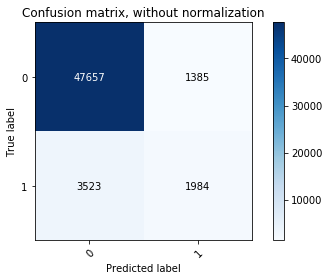

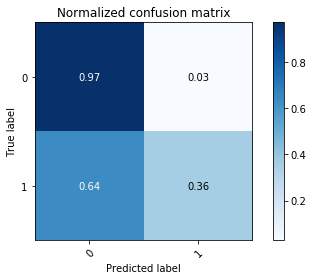

Accuracy:
0.9100258483198592
f1_score:
0.6990384680844037


In [29]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, normalize=True, title='Normalized confusion matrix')
plt.show()

# Accuracy
Accuracy = accuracy(y_test, y_pred)

As data are unbalanced, classifier predicts better the class 0 outputs (bigger class). It struggles to predict correctly results of class 1. Even if accuracy is high (91%), we need to look also on f1 score to compare models. F1 score is a metrics used for unbalanced data.

Compare results against a classifier that outputs random label:

Confusion matrix, without normalization
[[24464 24578]
 [ 2760  2747]]
Normalized confusion matrix
[[0.5 0.5]
 [0.5 0.5]]


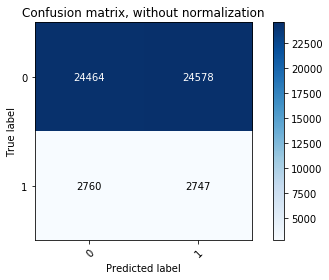

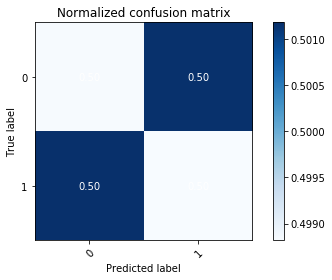

Accuracy:
0.4988359089992484
f1_score:
0.4044404070402713


In [30]:
# Accuracy of random class labels
y_random = np.random.randint(2, size=len(y_test))

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_random, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_random, normalize=True, title='Normalized confusion matrix')
plt.show()

Accuracy = accuracy(y_test, y_random)

Results of Bayesian Linear Regression are better that random results. Accuracy for random class label is around 50%, which is very intuitive. However even if overall accuracy of linear model is better that random results, still Bayesian Linear Regression model  is worst in predicting class 1 (36% vs 50%).  

In [31]:
# Code to help to choose threshold:

y_pred2_list = []  
threshold_list = []
Accuracy_list = []
f1_score_list = []

for i in np.arange(0.2, 1.0, 0.1):
    threshold = i

    Discretize_y = Discretize_predictions(Predicted_y_1order)
    # change datatype
    y_pred2 = np.asarray(Discretize_y, dtype=int)
    y_pred2_list.append(y_pred2)
    
    cm2 = confusion_matrix(y_test, y_pred2)
    Accuracy= (cm2[0,0]+cm2[1,1])/np.sum(cm2) # It's the same as: accuracy_score(y_test, y_pred, normalize=True)
     
    f1_score = metrics.f1_score(y_test, y_pred2, average='macro')
    
    threshold_list.append(i)
    Accuracy_list.append(Accuracy)
    f1_score_list.append(f1_score)
    

/mnt/workspace/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
# ploting accuracy metrics for different thresholds
threshold_results = pd.DataFrame(list(zip(threshold_list, Accuracy_list, f1_score_list )), 
               columns =['threshold', 'Accuracy', 'f1_score']) 
threshold_results 

,threshold,Accuracy,f1_score
0,0.2,0.833856,0.676957
1,0.3,0.910026,0.699038
2,0.4,0.907404,0.573988
3,0.5,0.900951,0.494475
4,0.6,0.899302,0.476199
5,0.7,0.899045,0.473420
6,0.8,0.899045,0.473420
7,0.9,0.899045,0.473420


From above table it's visible that the best result for accuracy and f1_score are for threshold around 0.3

## Logistic Regression

### 4a) (code) The goal is to implement a logistic regression classifier that optimizes for the Maximum a Posteriori (MAP) estimate; assume a Gaussian prior on the parameters.
As a first step, write a function that calculates the gradient of the joint likelihood using below equation

 <img src= "Eq1.PNG" width="800" height="600" align="center"/>


In [45]:
# Gradient of the joint likelihood
def gradient(w, X, y, sigma=1):
    sum1 = 0
    for i, xn in enumerate(X):
#       Pn =  probability_y_equal_1
        Pn =  1/(1+np.exp(-w.dot(xn))) 
        tn = y[i]
        sum1 += (xn *(tn - Pn))/X.shape[0]
    return -(w/sigma) + sum1


### b) (code) Write a simple gradient descend algorithm that uses the gradients calculated by the function of previous question to converge to the MAP estimate. [10]


In [46]:
def gradient_descent(X, y, sigma =1, learning_rate = 0.05, max_epochs = 100, stop_condition = 0.001):
        
    w = np.random.normal(0, 1, X.shape[1])

    dg_mean = 10  # set up only to allow implementation of stop condition
    dg_mean_list = []
    for i in range(1,max_epochs):
#       In order to reach optimum, first derivative should be close to zero. 
#       To check if algorithm works correctly I check if mean of all features of dg (gradient of the joint likelihood) is getting close to zero. 
#       The stop condition is implemented to allow algorithm to stop if it's close enough to optimum.
        if abs(dg_mean) > stop_condition:
            dg = gradient(w, X, y, sigma)
            w = w + learning_rate * dg 

            dg_mean =  np.mean(dg)
            dg_mean_list.append(dg_mean)
        else:
            print('Stop condition applied after', i, 'epochs')
            break
        
#         print(i, dg_mean)
        plt.figure(0)
        plt.plot(dg_mean_list) 
        plt.xlabel("Iterations")
        plt.ylabel("Gradient of the joint likelihood")
        plt.title("Joint likelihood gradient vs iterations")
    return w
    

In [51]:
# Function for Logistic regression predictions:
def  prediction_logistic_regression(X, y, X_new):
    w_new  = gradient_descent(X, y)
    P =  1/(1+np.exp(-X_new.dot(w_new).astype(float))) 
    return w_new, P      

Stop condition applied after 8 epochs


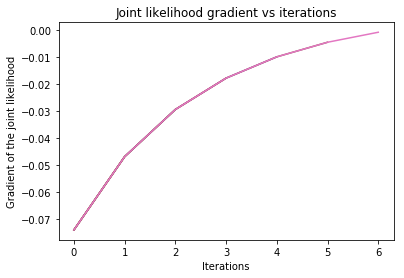

In [52]:
# Create preditions and plot 'Joint likelihood gradient vs iterations' figure
w_new, Prediction_logistic_regression = prediction_logistic_regression(X_train, y_train, X_test)

On the above figure It's visible that gradient of the joint likelihood is moving toward 0. It means it we can suspect that algorithm works correctly.

In [53]:
# Discretize and print prediction
# Discretize prediction
Discretize_y2 = np.around(Prediction_logistic_regression, decimals=0)
# Change datatype
y_pred_LR = np.asarray(Discretize_y2, dtype=int)
print(y_pred_LR)



[1 0 0 ... 0 0 0]


### c) (text) Comment on the convexity of the problem; do you need multiple restarts in order to obtain a solution sufficiently close to the global optimum? [5]


According to book "A First course in machine learning":  "One thing to notice from Hessian is that it will be negative definite for any set of xn and for any w. Therefore, there can be one optimum and it must be a maximum. Whatever value of w the Newton-Raphson procedure converges to must correspond to the highest value of the posterior density."
I didn't need multiple restarts to obtain a solution. However the choose of learning rate is smportant. If it's to high, dg will not converge. 

### d) (text) Report the confusion matrix and classification accuracy on the test data. Discuss logistic regression performance with respect to the performance of Bayesian linear regression [5]


Confusion matrix, without normalization
[[46300  2742]
 [ 5194   313]]
Normalized confusion matrix
[[0.94 0.06]
 [0.94 0.06]]


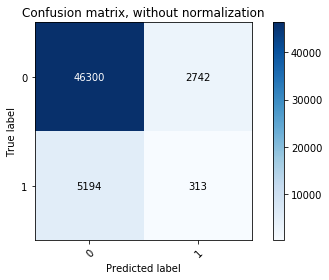

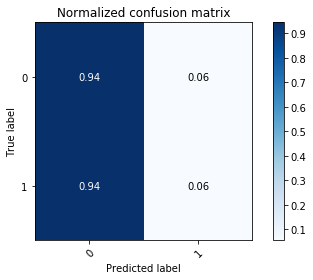

Accuracy:
0.854516123118664
f1_score:
0.4970884301210683


In [54]:

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_LR, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_LR, normalize=True, title='Normalized confusion matrix')
plt.show()

# Accuracy
Accuracy = accuracy(y_test, y_pred_LR)

Accuracy and F1 score of linear regression prediction was better.

### e) (text) Laplace approximation is an efficient way to obtain an approximate posterior for logistic regression. Describe the steps of this approach. What is the  form of approximation obtained? [5] 

1. Estimate 'w' using the previous code of gradient descent
2. Generating Gaussian to approximate g(w;X,t)
The parameters of the Gaussian are 

\begin{equation*}
\mu = \hat{w} 
\end{equation*}
\begin{equation}
\Sigma^{-1} = (\frac{\partial^{2}log(g(w;X,t))}{\partial{w}\partial{w^{T}}})
\end{equation}
    